# Step 1: Installing Required Dependencies

In [7]:
# Run in Colab
!apt-get update -qq
!apt-get install -y -qq tesseract-ocr libtesseract-dev poppler-utils
!pip install pdf2image

# Python packages
!pip install -q transformers sentencepiece spacy pytesseract pandas numpy fpdf streamlit==1.28.0
!python -m spacy download en_core_web_sm

# Install pyngrok
!pip install pyngrok

# Run Streamlit app with a public URL
# !streamlit run app.py & npx localtunnel --port 8501

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 64.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Step 2: Importing Required Python Libraries

In [8]:
import re
import io
import os
import json
import streamlit as st
from google.colab import sheets
from google.colab import data_table
from IPython.display import display
from fpdf import FPDF
import pytesseract
from PIL import Image
import pandas as pd
import numpy as np
import random
import spacy

# Load spaCy English language model
nlp = spacy.load("en_core_web_sm")


# Step 3: Creating Sample Symptom – Disease Mapping and Medicine Database

In [9]:
# Define a basic dictionary linking symptoms to possible diseases
symptom_db = {
    "fever": ["flu", "malaria", "common cold"],
    "cough": ["common cold", "flu", "bronchitis"],
    "sore throat": ["strep throat", "common cold", "flu"],
    "headache": ["migraine", "tension headache", "flu"],
    "fatigue": ["anemia", "dehydration", "flu"],
    "nausea": ["food poisoning", "gastritis", "migraine"],
    "chest pain": ["angina", "heart attack", "gastritis"],
    "shortness of breath": ["asthma", "COPD", "heart failure"],
    "abdominal pain": ["appendicitis", "ulcer", "gallstones"],
    "runny nose": ["common cold", "allergic rhinitis", "flu"],
    "joint pain": ["arthritis", "lupus", "gout"],
    "rash": ["allergic reaction", "measles", "eczema"],
    "vomiting": ["food poisoning", "stomach flu", "migraine"],
    "dizziness": ["vertigo", "dehydration", "anemia"]
}

# Convert dictionary to a pandas DataFrame for easier processing
symptom_map = pd.DataFrame([(s, d) for s, ds in symptom_db.items() for d in ds], columns=["symptom","disease"])

# Display first few records
symptom_map.head()


,symptom,disease
0,fever,flu
1,fever,malaria
2,fever,common cold
3,cough,common cold
4,cough,flu


In [10]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=symptom_map)

https://docs.google.com/spreadsheets/d/1vV3KqWsnmOXR7MCj1iZk9M5e42rQOtAojie6rsSvdZU/edit#gid=0


# Step 4: Medicines DB

In [11]:
# --- STEP 1: Import all required libraries ---
# from google.colab import data_table  # used instead of 'sheets' (InteractiveSheet is deprecated)

# --- STEP 2: Define initial medicine list ---
meds = [
    {"name":"Paracetamol", "info":"Analgesic/fever reducer. Typical adult dose 500-1000 mg every 4-6 hours."},
    {"name":"Azithromycin", "info":"Antibiotic. Take as prescribed; usually after food."},
    {"name":"Cetirizine", "info":"Antihistamine for allergies; may cause drowsiness."},
    {"name":"Amoxicillin", "info":"Antibiotic — complete full course as prescribed."},
    {"name": "Ibuprofen", "info": "NSAID used for pain and inflammation. Take after meals to avoid stomach upset."},
    {"name": "Metformin", "info": "Used for type 2 diabetes. Take with food to reduce stomach upset."},
    {"name": "Loratadine", "info": "Non-drowsy antihistamine for allergies."},
    {"name": "Omeprazole", "info": "Reduces stomach acid; take 30 mins before meals."},
    {"name": "Amlodipine", "info": "Used for high blood pressure; take at the same time daily."},
    {"name": "Losartan", "info": "Angiotensin receptor blocker for hypertension."},
    {"name": "Salbutamol", "info": "Bronchodilator for asthma; use inhaler as directed."},
    {"name": "Doxycycline", "info": "Antibiotic; avoid sunlight exposure while on medication."},
    {"name": "Prednisolone", "info": "Steroid anti-inflammatory; do not stop abruptly."},
    {"name": "Atorvastatin", "info": "Lowers cholesterol; take once daily at night."}
]

# --- STEP 3: Convert to DataFrame
meds_df = pd.DataFrame(meds)
meds_df.insert(0, "ID", range(1, len(meds_df)+1))  # Add ID column starting from 1

# Save as CSV
meds_df.to_csv("medicines.csv", index=False)
print("✅ medicines.csv created successfully!")

# Display
display(meds_df.head())

✅ medicines.csv created successfully!


,ID,name,info
0,1,Paracetamol,Analgesic/fever reducer. Typical adult dose 50...
1,2,Azithromycin,Antibiotic. Take as prescribed; usually after ...
2,3,Cetirizine,Antihistamine for allergies; may cause drowsin...
3,4,Amoxicillin,Antibiotic — complete full course as prescribed.
4,5,Ibuprofen,NSAID used for pain and inflammation. Take aft...


In [12]:
# --- STEP 4: Generate additional random medicines ---
medicine_names = [
    "Paracetamol", "Amoxicillin", "Azithromycin", "Ibuprofen",
    "Metformin", "Amlodipine", "Omeprazole", "Cetirizine",
    "Losartan", "Salbutamol", "Doxycycline", "Prednisolone",
    "Atorvastatin", "Levothyroxine", "Insulin", "Ciprofloxacin",
    "Hydrochlorothiazide", "Clopidogrel", "Montelukast", "Vitamin D3"
]

descriptions = [
    "Used for pain or fever.",
    "Antibiotic — take full course.",
    "Antihistamine; may cause drowsiness.",
    "Used for blood pressure control.",
    "Used for diabetes management.",
    "Reduces stomach acid production.",
    "Bronchodilator for asthma.",
    "Lowers cholesterol levels.",
    "Take with food to prevent nausea.",
    "May interact with alcohol."
]

# Create new medicine entries
extra_meds = [{"name": name, "info": random.choice(descriptions)} for name in medicine_names]

# Avoid duplicates
existing_names = {m["name"] for m in meds}
for m in extra_meds:
    if m["name"] not in existing_names:
        meds.append(m)

# --- STEP 5: Rebuild DataFrame and save expanded list ---
meds_df = pd.DataFrame(meds)
meds_df.insert(0, "ID", range(1, len(meds_df) + 1))
meds_df.to_csv("medicines_expanded.csv", index=False)
print("✅ medicines_expanded.csv created successfully!")
display(meds_df.head())


✅ medicines_expanded.csv created successfully!


,ID,name,info
0,1,Paracetamol,Analgesic/fever reducer. Typical adult dose 50...
1,2,Azithromycin,Antibiotic. Take as prescribed; usually after ...
2,3,Cetirizine,Antihistamine for allergies; may cause drowsin...
3,4,Amoxicillin,Antibiotic — complete full course as prescribed.
4,5,Ibuprofen,NSAID used for pain and inflammation. Take aft...


## **1. Interactive DataTable**

In [13]:
# --- STEP 6: Interactive DataTable for editing (Colab compatible) ---
# from google.colab import data_table

data_table.enable_dataframe_formatter()  # enables nice UI
display(meds_df)

,ID,name,info
0,1,Paracetamol,Analgesic/fever reducer. Typical adult dose 50...
1,2,Azithromycin,Antibiotic. Take as prescribed; usually after ...
2,3,Cetirizine,Antihistamine for allergies; may cause drowsin...
3,4,Amoxicillin,Antibiotic — complete full course as prescribed.
4,5,Ibuprofen,NSAID used for pain and inflammation. Take aft...
5,6,Metformin,Used for type 2 diabetes. Take with food to re...
6,7,Loratadine,Non-drowsy antihistamine for allergies.
7,8,Omeprazole,Reduces stomach acid; take 30 mins before meals.
8,9,Amlodipine,Used for high blood pressure; take at the same...
9,10,Losartan,Angiotensin receptor blocker for hypertension.


# Quick Search Function

In [14]:
from IPython.display import display
import pandas as pd

# --- STEP 7: Functions to update and search medicines ---
def get_updated_meds():
    """Reload updated medicines from the expanded CSV."""
    meds_df = pd.read_csv("medicines_expanded.csv")

    # ✅ Fix: only add ID column if it doesn't already exist
    if "ID" not in meds_df.columns:
        meds_df.insert(0, "ID", range(1, len(meds_df) + 1))
    return meds_df

def search_medicine(name):
    """Search a medicine by name (case-insensitive)."""
    meds_df = get_updated_meds()
    result = meds_df[meds_df['name'].str.contains(name, case=False, na=False)]
    if result.empty:
        return None
    else:
        return result

# --- STEP 8: Run multiple searches and display results ---
search_terms = ["Ibuprofen", "Paracetamol"]

for term in search_terms:
    print(f"\n🔍 Searching for '{term}'...\n")
    result = search_medicine(name=term)

    if result is not None:
        print(f"✅ {len(result)} match(es) found for '{term}':")
        display(result)
    else:
        print(f"❌ No medicine found matching '{term}'")

print("\n✅ Search complete for all medicines.")



🔍 Searching for 'Ibuprofen'...

✅ 1 match(es) found for 'Ibuprofen':


,ID,name,info
4,5,Ibuprofen,NSAID used for pain and inflammation. Take aft...



🔍 Searching for 'Paracetamol'...

✅ 1 match(es) found for 'Paracetamol':


,ID,name,info
0,1,Paracetamol,Analgesic/fever reducer. Typical adult dose 50...



✅ Search complete for all medicines.


**1️⃣ Symptom Extraction Function**

In [15]:
import spacy

# Make sure you have already loaded spaCy model
# nlp = spacy.load("en_core_web_sm")

def extract_symptoms(text, symptom_db):
    """
    Extract symptom phrases from free text using:
    1. direct keyword matching
    2. spaCy noun chunks as fallback
    """
    text = text.lower()
    found = set()

    # 1️⃣ Direct keyword matching
    for symptom in symptom_db.keys():
        if symptom in text:
            found.add(symptom)

    # 2️⃣ spaCy noun chunk fallback
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        chunk_text = chunk.text.lower().strip()
        if chunk_text in symptom_db.keys():
            found.add(chunk_text)

    return list(found)


**2️⃣ Diagnosis Function**

In [16]:
def diagnose(symptoms, symptom_db):
    """
    Score diseases by number of matching symptoms
    and provide confidence heuristic.
    """
    score = {}
    for symptom in symptoms:
        for disease in symptom_db.get(symptom, []):
            score[disease] = score.get(disease, 0) + 1

    # Sort diseases by score descending
    sorted_diseases = sorted(score.items(), key=lambda x: x[1], reverse=True)

    results = []
    if len(sorted_diseases) == 0:
        return results

    max_score = sorted_diseases[0][1]

    # Map score to confidence percentage (50% base + relative match)
    for disease, sc in sorted_diseases:
        conf = round(50 + (sc / max_score) * 50) if max_score > 0 else 50
        results.append({"disease": disease, "score": sc, "confidence": conf})

    return results


**3️⃣ Example Usage**

In [17]:
# Example symptom database
# symptom_db = {"fever": ["Flu", "Common Cold"], "cough": ["Flu", "Bronchitis"], ...}

# ✅ Example input text
text = "I have fever and cough since yesterday, slight headache and sore throat."

# --- Extract symptoms ---
symptoms = extract_symptoms(text, symptom_db)
print("🩺 Symptoms found:", symptoms if symptoms else "No symptoms detected.")

# --- Diagnose possible diseases ---
diagnosis_results = diagnose(symptoms, symptom_db)

# --- Display results ---
if diagnosis_results:
    print("\n🧠 Possible Diagnoses:")
    for d in diagnosis_results:
        print(f"• {d['disease']}  —  Confidence: {d['confidence']}% (Score: {d['score']})")
else:
    print("\n⚠️ No diagnosis could be made. Please describe more symptoms.")

# --- Optional: quick summary output ---
print("\n✅ Diagnosis process complete.")

🩺 Symptoms found: ['fever', 'sore throat', 'headache', 'cough']

🧠 Possible Diagnoses:
• flu  —  Confidence: 100% (Score: 4)
• common cold  —  Confidence: 88% (Score: 3)
• malaria  —  Confidence: 62% (Score: 1)
• strep throat  —  Confidence: 62% (Score: 1)
• migraine  —  Confidence: 62% (Score: 1)
• tension headache  —  Confidence: 62% (Score: 1)
• bronchitis  —  Confidence: 62% (Score: 1)

✅ Diagnosis process complete.


**4️⃣ Optional Integration with Medicines DB**

In [18]:
def recommend_medicines(diseases, med_df, diagnosis_results=None):
    """
    🔹 Upgraded Medicine Recommendation System
    Suggests medicines based on disease matches, with optional confidence scoring.

    Args:
        diseases (list): List of disease names (e.g., from diagnose()).
        med_df (pd.DataFrame): Medicines DataFrame with 'name' and 'info'.
        diagnosis_results (list of dict, optional): From diagnose(), used to rank by confidence.

    Returns:
        pd.DataFrame: Filtered medicine recommendations with source disease.
    """
    # 🧠 Disease-to-Medicine mapping
    disease_meds = {
        "Flu": ["Paracetamol", "Azithromycin"],
        "Common Cold": ["Paracetamol", "Cetirizine"],
        "Bronchitis": ["Salbutamol", "Azithromycin"],
        "Asthma": ["Salbutamol"],
        "Strep Throat": ["Amoxicillin", "Paracetamol"],
        "Migraine": ["Ibuprofen"],
        "Tension Headache": ["Ibuprofen", "Paracetamol"],
        "Allergy": ["Cetirizine", "Loratadine"],
        "Sinus Infection": ["Amoxicillin", "Paracetamol"]
    }

    # 🧩 Collect matching medicines
    recs = []
    for disease in diseases:
        meds = disease_meds.get(disease, [])
        for med in meds:
            if med in med_df['name'].values:
                info = med_df.loc[med_df['name'] == med, 'info'].values[0]
                conf = None
                if diagnosis_results:
                    for d in diagnosis_results:
                        if d['disease'] == disease:
                            conf = d['confidence']
                recs.append({
                    "disease": disease,
                    "medicine": med,
                    "info": info,
                    "confidence": conf
                })

    # ✅ Convert to DataFrame
    rec_df = pd.DataFrame(recs)

    if rec_df.empty:
        print("⚠️ No matching medicines found for given diseases.")
        return pd.DataFrame(columns=["disease", "medicine", "info", "confidence"])

    # Optional sorting by confidence
    if diagnosis_results and "confidence" in rec_df.columns:
        rec_df = rec_df.sort_values(by="confidence", ascending=False, na_position="last")

    return rec_df.reset_index(drop=True)


# Example Usage

In [19]:
# Suppose diagnosis_results came from the diagnose() function

# First diagnosis result
diagnosis_results_1 = [
    {"disease": "Flu", "score": 3, "confidence": 95},
    {"disease": "Common Cold", "score": 2, "confidence": 80}
]

# Second diagnosis result
diagnosis_results_2 = [
    {"disease": "Allergy", "score": 4, "confidence": 90},
    {"disease": "Sinus Infection", "score": 3, "confidence": 85}
]

# ✅ Combine both diagnosis lists
diagnosis_results = diagnosis_results_1 + diagnosis_results_2

# Extract disease names
diseases = [d["disease"] for d in diagnosis_results]

# Get medicine recommendations
recommended = recommend_medicines(diseases, meds_df, diagnosis_results)

# Display the result
print("\n💊 Recommended Medicines:")
display(recommended)



💊 Recommended Medicines:


,disease,medicine,info,confidence
0,Flu,Paracetamol,Analgesic/fever reducer. Typical adult dose 50...,95
1,Flu,Azithromycin,Antibiotic. Take as prescribed; usually after ...,95
2,Allergy,Cetirizine,Antihistamine for allergies; may cause drowsin...,90
3,Allergy,Loratadine,Non-drowsy antihistamine for allergies.,90
4,Sinus Infection,Amoxicillin,Antibiotic — complete full course as prescribed.,85
5,Sinus Infection,Paracetamol,Analgesic/fever reducer. Typical adult dose 50...,85
6,Common Cold,Paracetamol,Analgesic/fever reducer. Typical adult dose 50...,80
7,Common Cold,Cetirizine,Antihistamine for allergies; may cause drowsin...,80


# Step 5: Prescription OCR + Medicine Extraction

**1️⃣ OCR Helper Function**

In [20]:
import pytesseract
from PIL import Image

def ocr_image_to_text(image_path_or_pil):
    """
    Extract text from prescription image using pytesseract.
    Accepts a file path or PIL.Image object.
    Returns extracted text as a string.
    """
    if isinstance(image_path_or_pil, str):
        img = Image.open(image_path_or_pil)
    else:
        img = image_path_or_pil

    text = pytesseract.image_to_string(img)
    return text

**2️⃣ Medicine Extraction Function**

In [21]:
import re

def extract_medicines_from_text(text, meds_df):
    """
    Extract medicine names from OCR text using the live medicines DataFrame.
    Returns a list of dictionaries with medicine name, info, and status.
    Flags unknown medicines that are not in meds_df.
    """
    found = []
    t = text.lower()

    # 1️⃣ Match against live medicines sheet (exact or partial match)
    for name in meds_df['name'].tolist():
        if name.lower() in t:
            info = meds_df[meds_df['name'] == name]['info'].values[0]
            found.append({"name": name, "info": info, "status": "known"})

    # 2️⃣ Regex to catch dosage mentions like 'Paracetamol 500 mg' or 'Ibuprofen 200mg'
    rx = re.findall(r'([A-Za-z]+(?:\s*[A-Za-z]*)+)\s*\d{2,4}\s*(mg|ml|tablet[s]?)', text, flags=re.I)
    for r in rx:
        nm = r[0].strip()
        # Avoid duplicates already found
        if nm and not any(nm.lower() in m['name'].lower() for m in found):
            found.append({
                "name": nm,
                "info": "(Auto-detected) check dosage on prescription label.",
                "status": "unknown"
            })

    return found

**3️⃣ Example Usage**

In [22]:
# ✅ Example medicines DataFrame
meds_df = pd.DataFrame({
    "name": ["Paracetamol", "Ibuprofen", "Cetirizine", "Amoxicillin"],
    "info": [
        "Pain reliever and fever reducer",
        "Pain reliever for inflammation",
        "Antihistamine for allergies",
        "Antibiotic for bacterial infections"
    ]
})

# ✅ Simulated OCR text (as if extracted from an image)
ocr_text = """
Patient: John Doe
Prescription:
- Paracetamol 500 mg, twice a day
- Ibuprofen 200mg if headache persists
- Vitamin C tablets
"""

# ✅ Extract medicine data
found_meds = extract_medicines_from_text(ocr_text, meds_df)

# ✅ Display results
print("🩺 OCR Text:\n", ocr_text)
print("\n💊 Extracted Medicines:")
for med in found_meds:
    print(f"- {med['name']} ({med['status']}): {med['info']}")


# Example (assuming image exists and pytesseract is set up)
# image_path = "sample_prescription.jpg"
# ocr_text = ocr_image_to_text(image_path)
# extracted_meds = extract_medicines_from_text(ocr_text, meds_df)

# Display results
# for med in extracted_meds:
#     print(med)

🩺 OCR Text:
 
Patient: John Doe
Prescription:
- Paracetamol 500 mg, twice a day
- Ibuprofen 200mg if headache persists
- Vitamin C tablets


💊 Extracted Medicines:
- Paracetamol (known): Pain reliever and fever reducer
- Ibuprofen (known): Pain reliever for inflammation


# **Sample Prescription**

Please select your prescription image (e.g., medical_prescription.jpg):


Saving medical_prescription.jpg to medical_prescription.jpg

✅ Uploaded: medical_prescription.jpg


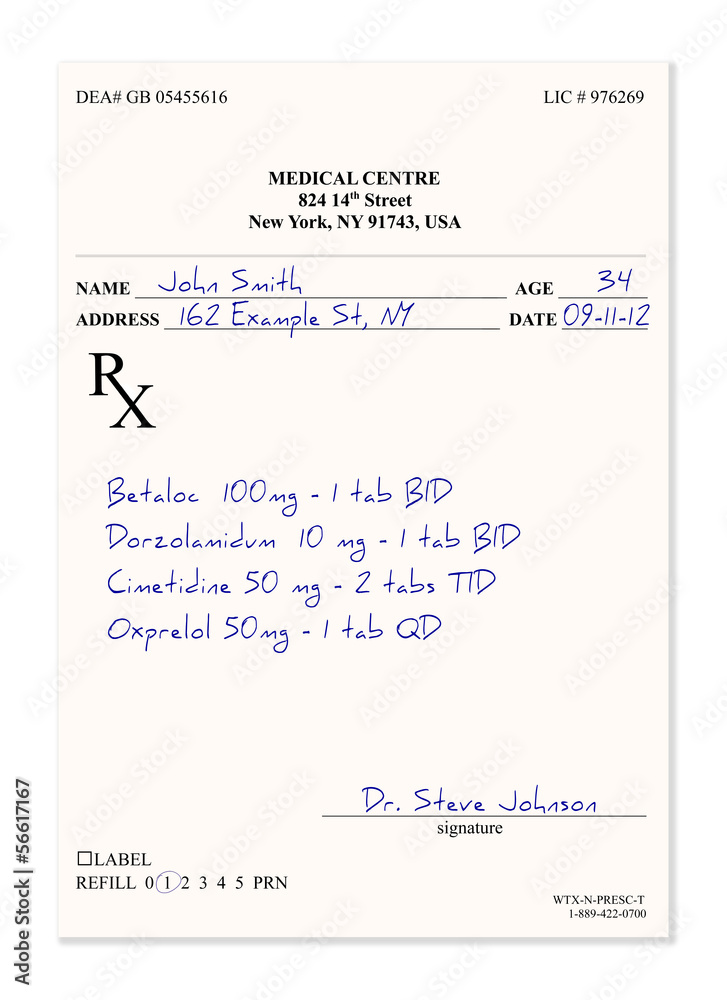

In [23]:
# 🩺 Step 1: Upload and Display Prescription Image
from google.colab import files
from IPython.display import Image, display

# 📤 Upload image
print("Please select your prescription image (e.g., medical_prescription.jpg):")
uploaded = files.upload()

# ✅ Get file name
image_name = list(uploaded.keys())[0]
print(f"\n✅ Uploaded: {image_name}")

# 👁️ Display the uploaded image
display(Image(filename=image_name))


In [24]:
import pandas as pd
#display(pd.DataFrame(found_meds))
print("Text extracted from image:\n")
print(text)

Text extracted from image:

I have fever and cough since yesterday, slight headache and sore throat.


In [25]:
import os
print(os.listdir('/content/'))

['.config', 'medicines_expanded.csv', 'medical_prescription.jpg', 'medicines.csv', 'sample_data']


# Step 6: PDF report generator

In [26]:
from fpdf import FPDF

def generate_report_pdf(patient_name, age, symptoms, diagnosis_results, medicines, filename="carebot_report.pdf", top_n=5):
    """
    Generate a PDF health report with patient info, symptoms, diagnosis, and medicines.

    Args:
        patient_name (str): Name of the patient
        age (int): Patient age
        symptoms (list): List of symptom strings
        diagnosis_results (list of dicts): Output from diagnose(), each dict contains 'disease', 'score', 'confidence'
        medicines (list of dicts): Extracted medicines [{'name':..., 'info':..., 'status':...}]
        filename (str): Output PDF file name
        top_n (int): Number of top diagnoses to show

    Returns:
        str: The filename of the generated PDF
    """
    pdf = FPDF()
    pdf.add_page()

    # --- Title ---
    pdf.set_font("Arial", "B", size=16)
    pdf.cell(0, 10, txt="CareBot AI - Health Summary", ln=True, align='C')
    pdf.ln(5)
    pdf.set_line_width(0.5)
    pdf.line(10, pdf.get_y(), 200, pdf.get_y())
    pdf.ln(5)

    # --- Patient Info ---
    pdf.set_font("Arial", "B", size=12)
    pdf.cell(0, 8, txt=f"Patient Name: {patient_name}", ln=True)
    pdf.cell(0, 8, txt=f"Age: {age}", ln=True)
    pdf.ln(3)

    # --- Symptoms ---
    pdf.set_font("Arial", "B", size=12)
    pdf.cell(0, 8, txt="Symptoms Reported:", ln=True)
    pdf.set_font("Arial", size=12)
    for s in symptoms:
        pdf.cell(0, 6, txt=f"- {s}", ln=True)
    pdf.ln(3)

    # --- Diagnosis ---
    pdf.set_font("Arial", "B", size=12)
    pdf.cell(0, 8, txt=f"Top {top_n} Diagnosis Suggestions:", ln=True)
    pdf.set_font("Arial", size=12)
    for di in diagnosis_results[:top_n]:
        pdf.cell(0, 6, txt=f"- {di['disease']} (Confidence: {di['confidence']}%)", ln=True)
    pdf.ln(3)

    # --- Medicines ---
    if medicines:
        pdf.set_font("Arial", "B", size=12)
        pdf.cell(0, 8, txt="Medicines Extracted from Prescription:", ln=True)
        pdf.set_font("Arial", size=12)
        for m in medicines:
            status = f" [{m.get('status','')}]"
            pdf.multi_cell(0, 6, txt=f"- {m['name']}{status}: {m['info']}")
        pdf.ln(2)

    # --- Disclaimer ---
    pdf.set_font("Arial", "I", size=9)
    pdf.multi_cell(0, 5, txt="Disclaimer: This is an AI-assisted pre-diagnosis tool for educational purposes only. "
                               "Please consult a medical professional for a definitive diagnosis.")

    # --- Save PDF ---
    pdf.output(filename)
    return filename


**2️⃣ Example Usage 1**

In [27]:
# Example test
patient_name = "abi"
age = 25
symptoms = ["fever", "cough"]
# Pass symptom_db
diagnosis_results = diagnose(symptoms, symptom_db)

#diagnosis_results = diagnose(symptoms)  # from Cell 3
medicines = [{"name":"Paracetamol","info":"Analgesic/fever reducer..."}]

pdf_file = generate_report_pdf(patient_name, age, symptoms, diagnosis_results, medicines, filename="abi_test_report.pdf")
print("PDF generated:", pdf_file)


PDF generated: abi_test_report.pdf


**3️⃣ Example Usage 2**

In [28]:
# Patient 2: Arjun
patient_name = "Arjun"
age = 35
symptoms = ["headache", "fatigue", "sore throat"]
# Pass symptom_db
diagnosis_results = diagnose(symptoms, symptom_db)

#diagnosis_results = diagnose(symptoms)
medicines = [
    {"name":"Ibuprofen","info":"Pain relief and inflammation; take after meals","status":"known"},
    {"name":"Vitamin C","info":"Supplement; helps with immunity","status":"unknown"}
]

pdf_file2 = generate_report_pdf(patient_name, age, symptoms, diagnosis_results, medicines, filename="arjun_report.pdf")
print("PDF generated:", pdf_file2)


PDF generated: arjun_report.pdf


# Step 7: Minimal Conversational Function

In [29]:
def carebot_session(patient_name, age, user_text, symptom_db, prescription_image_path=None):
    """
    Minimal conversational session combining:
    - Symptom extraction
    - Diagnosis
    - Prescription OCR (optional)
    - Medicine extraction
    - PDF report generation

    Args:
        patient_name (str): Patient name
        age (int): Patient age
        user_text (str): Free-text description of symptoms
        symptom_db (dict): Mapping of symptom -> list of diseases
        prescription_image_path (str, optional): Path to prescription image

    Returns:
        dict: Summary containing symptoms, diagnosis, medicines, OCR excerpt, and PDF file
    """
    # --- 1. Extract symptoms ---
    symptoms = extract_symptoms(user_text, symptom_db)

    # --- 2. Diagnose diseases ---
    diagnosis_results = diagnose(symptoms, symptom_db)

    # --- 3. Initialize medicines and OCR text ---
    meds_found = []
    ocr_text = ""

    if prescription_image_path:
        # OCR from image
        ocr_text = ocr_image_to_text(prescription_image_path)
        # Extract medicines from OCR text
        meds_found = extract_medicines_from_text(ocr_text, meds_df)

    # --- 4. Generate PDF report ---
    pdf_filename = f"carebot_{patient_name.replace(' ','_')}.pdf"
    pdf_file = generate_report_pdf(
        patient_name=patient_name,
        age=age,
        symptoms=symptoms,
        diagnosis_results=diagnosis_results,
        medicines=meds_found,
        filename=pdf_filename
    )

    # --- 5. Assemble summary ---
    summary = {
        "patient": patient_name,
        "age": age,
        "symptoms": symptoms,
        "diagnosis": diagnosis_results,
        "medicines": meds_found,
        "ocr_text_excerpt": ocr_text[:500],  # first 500 chars of OCR text
        "pdf": pdf_file
    }

    return summary


In [30]:
print("Check before running:")
print("carebot_session:", 'defined' if 'carebot_session' in globals() else 'missing')
print("symptom_db:", 'defined' if 'symptom_db' in globals() else 'missing')
print("meds_df:", 'defined' if 'meds_df' in globals() else 'missing')
print("Image exists:", os.path.exists('/content/medical_prescription.jpg'))


Check before running:
carebot_session: defined
symptom_db: defined
meds_df: defined
Image exists: True


In [31]:
# Demo session without prescription image
session = carebot_session(
    patient_name="mona",
    age=26,
    user_text="I have fever and sore throat and cough",
    symptom_db=symptom_db,
    # prescription_image_path='/content/medical_prescription.jpg'  # removed image path
)

# Inspect summary
session

{'patient': 'mona',
 'age': 26,
 'symptoms': ['fever', 'sore throat', 'cough'],
 'diagnosis': [{'disease': 'flu', 'score': 3, 'confidence': 100},
  {'disease': 'common cold', 'score': 3, 'confidence': 100},
  {'disease': 'malaria', 'score': 1, 'confidence': 67},
  {'disease': 'strep throat', 'score': 1, 'confidence': 67},
  {'disease': 'bronchitis', 'score': 1, 'confidence': 67}],
 'medicines': [],
 'ocr_text_excerpt': '',
 'pdf': 'carebot_mona.pdf'}

# Step 8: Streamlit app

In [32]:
# app.py
from PIL import Image
import tempfile
import os

# --- Import CareBot utility functions ---
# from carebot_utils import extract_symptoms, diagnose, ocr_image_to_text, extract_medicines_from_text, generate_report_pdf, carebot_session
# For simplicity, paste all function definitions here if carebot_utils.py is not used

# --- Streamlit UI ---
st.set_page_config(page_title="CareBot AI", layout="centered")
st.title("CareBot AI — Medical Chat Assistant")
st.write("A lightweight AI assistant for symptom analysis and prescription reading. For educational use only.")

with st.form("patient_form"):
    name = st.text_input("Name", value="Ramya")
    age = st.number_input("Age", min_value=0, max_value=120, value=22)
    user_text = st.text_area("Describe your symptoms (in short):", value="I have fever and sore throat")
    prescription = st.file_uploader("Upload prescription / report (image/pdf)", type=["png","jpg","jpeg","pdf"])
    submitted = st.form_submit_button("Analyze")

if submitted:
    pres_path = None
    temp_files = []

    if prescription:
        # save uploaded file temporarily
        tfile = tempfile.NamedTemporaryFile(delete=False)
        tfile.write(prescription.getvalue())
        tfile.close()
        pres_path = tfile.name
        temp_files.append(pres_path)

        # convert PDF to image (first page) if needed
        if pres_path.lower().endswith(".pdf"):
            from pdf2image import convert_from_path
            pages = convert_from_path(pres_path, 200, first_page=1, last_page=1)
            img = pages[0]
            tmpimg = pres_path + ".png"
            img.save(tmpimg, "PNG")
            pres_path = tmpimg
            temp_files.append(tmpimg)

    # --- Call CareBot session ---
    summary = carebot_session(name, age, user_text, symptom_db, prescription_image_path=pres_path)

    # --- Display Results ---
    st.subheader("Detected symptoms")
    st.write(summary["symptoms"] or "No clear symptoms detected.")

    st.subheader("Top suggestions")
    if summary["diagnosis"]:
        for d in summary["diagnosis"]:
            st.write(f"- {d['disease']} (confidence ~{d['confidence']}%)")
    else:
        st.write("No suggestion found. Please consult a doctor.")

    if summary["medicines"]:
        st.subheader("Medicines found in prescription/report")
        for m in summary["medicines"]:
            status = f" ({m['status']})" if "status" in m else ""
            st.write(f"- **{m['name']}**{status}: {m['info']}")
    else:
        st.write("No medicines detected from prescription.")

    st.download_button(
        "Download report (PDF)",
        data=open(summary["pdf"], "rb").read(),
        file_name=os.path.basename(summary["pdf"]),
        mime="application/pdf")

2025-10-28 07:45:54.277 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]


In [33]:
# Demo run
session = carebot_session(patient_name="lakshmi", age=35, user_text="I have headache and sore throat and cough", symptom_db=symptom_db)
print("Symptoms:", session["symptoms"])
print("Top suggestions:", session["diagnosis"])
print("Generated PDF:", session["pdf"])

Symptoms: ['sore throat', 'headache', 'cough']
Top suggestions: [{'disease': 'flu', 'score': 3, 'confidence': 100}, {'disease': 'common cold', 'score': 2, 'confidence': 83}, {'disease': 'strep throat', 'score': 1, 'confidence': 67}, {'disease': 'migraine', 'score': 1, 'confidence': 67}, {'disease': 'tension headache', 'score': 1, 'confidence': 67}, {'disease': 'bronchitis', 'score': 1, 'confidence': 67}]
Generated PDF: carebot_lakshmi.pdf


In [34]:
from google.colab import files

files.download('carebot_mona.pdf')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
import os

file_list = os.listdir('/content/')
jpg_files = [f for f in file_list if f.endswith('.jpg') or f.endswith('.jpeg')]

if jpg_files:
    print("Available JPG files in /content/:")
    for jpg_file in jpg_files:
        print(f"- {jpg_file}")
else:
    print("No JPG files found in /content/.")

Available JPG files in /content/:
- medical_prescription.jpg
